In [2]:
library(tidyverse)

library(caret)
library(recipes)

### 타겟 엔지니어링

In [14]:
ames <- AmesHousing::make_ames()
set.seed(123)
index <- createDataPartition(ames$Sale_Price, p = 0.7,
                            list = F)
ames_train <- ames[index,]
ames_test <- ames[-index, ]
dim(ames_train) ; dim(ames_test)

[1] 2053   81

[1] 877  81

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



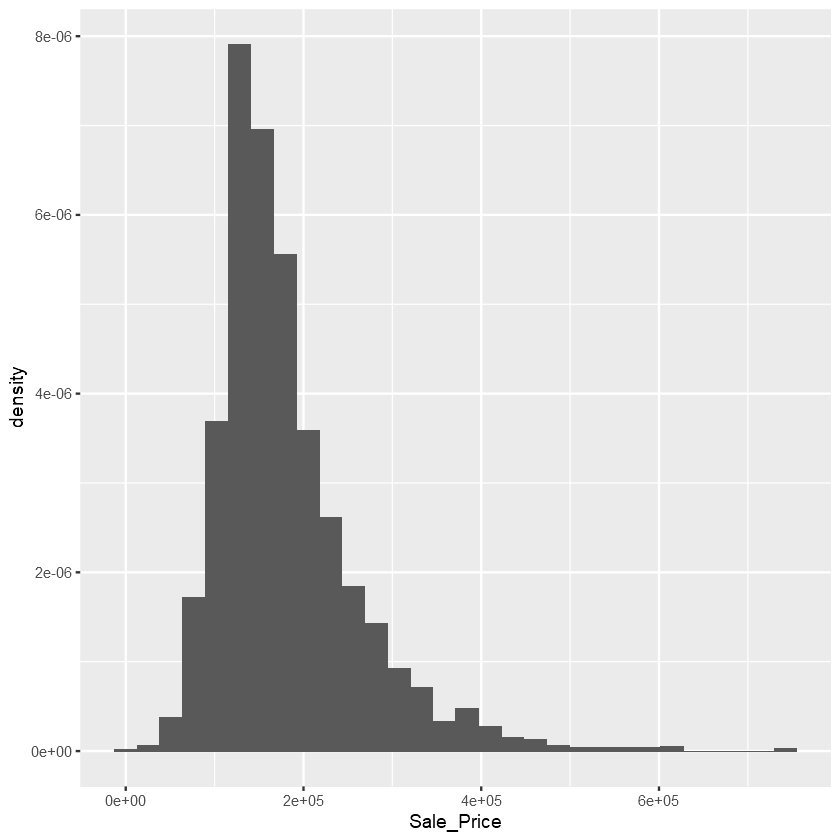

In [11]:
ggplot(ames) + geom_histogram(aes(Sale_Price, y = ..density..))

- 일반 선형 회귀 모델은 예측 오류(반응변수)가 정규 분포를 따른다고 가정
- 예측 대상에 이상치가 있거나 한 방향 또는 다른 방향으로 치우친 경우를 제외하고는 일반적으로 문제가 없음.
- 이러한 경우 정규성 가정이 성립하지 않음

### - 반응 왜도를 최소화 하기 위해서 
### 1. 로그변환

1.

In [24]:
transformed_response <- log(ames_train$Sale_Price)

2.  ```caret::preProcess()```

In [27]:
ames_recipe <- recipe(Sale_Price ~ ., data = ames_train) %>%
  step_log(all_outcomes())
ames_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()

- 반응변수에 음수 값이나 0이 있는 경우 로그 변환은 각각 ```NaN```과 ```-Inf```를 생성

### 2. Box Cox변환
<img src = "https://miro.medium.com/max/884/1*_nHvGg-OQYtNSSZph-424g.png">

- Box Cox 변환은 로그 변환보다 유연하며(특별한 경우도 포함) 정규 분포에 최대한 가깝게 변수를 변환하는 거듭제곱 변환 계열에서 적절한 변환을 찾음

In [ ]:
library(forecast)
forecast::BoxCox(10, lambda)

### 결측값

In [29]:
sum(is.na(AmesHousing::ames_raw))

[1] 13997

#### 결측값 시각화
### - ```geom_raster()```

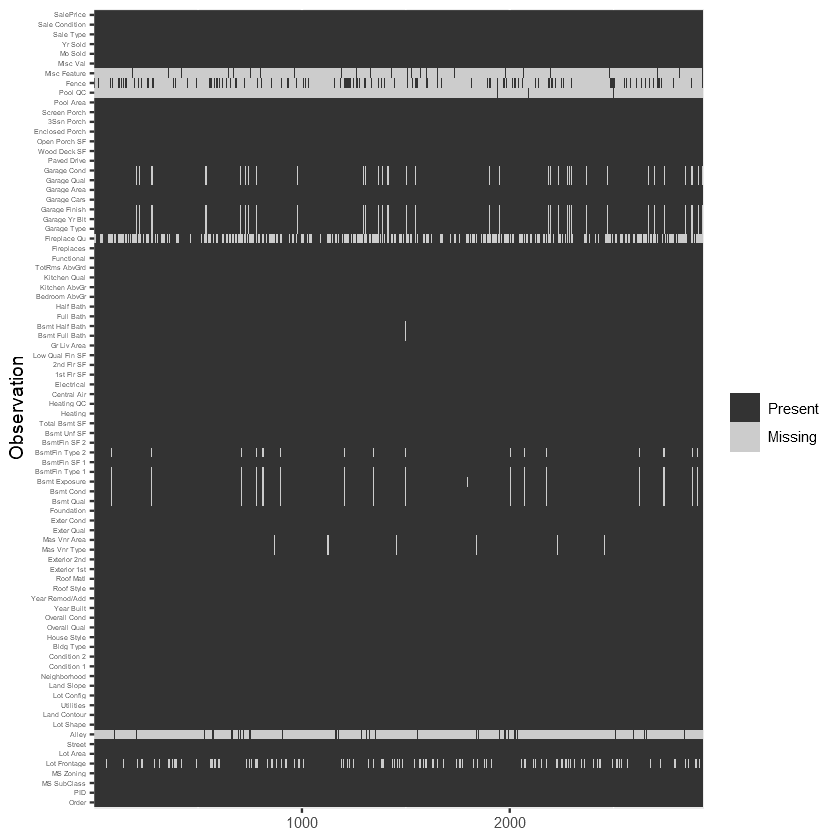

In [30]:
AmesHousing::ames_raw %>%
  is.na() %>%
  reshape2::melt() %>%
  ggplot(aes(Var2, Var1, fill = value)) + 
    geom_raster() + 
    coord_flip() +
    scale_y_continuous(NULL, expand = c(0, 0)) +
    scale_fill_grey(name = "", 
                    labels = c("Present", 
                               "Missing")) +
    xlab("Observation") +
    theme(axis.text.y  = element_text(size = 4))

In [31]:
AmesHousing::ames_raw %>% 
  filter(is.na(`Garage Type`)) %>% 
  select(`Garage Type`, `Garage Cars`, `Garage Area`) %>% print

# A tibble: 157 x 3
   `Garage Type` `Garage Cars` `Garage Area`
   <chr>                 <int>         <int>
 1 NA                        0             0
 2 NA                        0             0
 3 NA                        0             0
 4 NA                        0             0
 5 NA                        0             0
 6 NA                        0             0
 7 NA                        0             0
 8 NA                        0             0
 9 NA                        0             0
10 NA                        0             0
# ... with 147 more rows


### - ```vis_miss()```

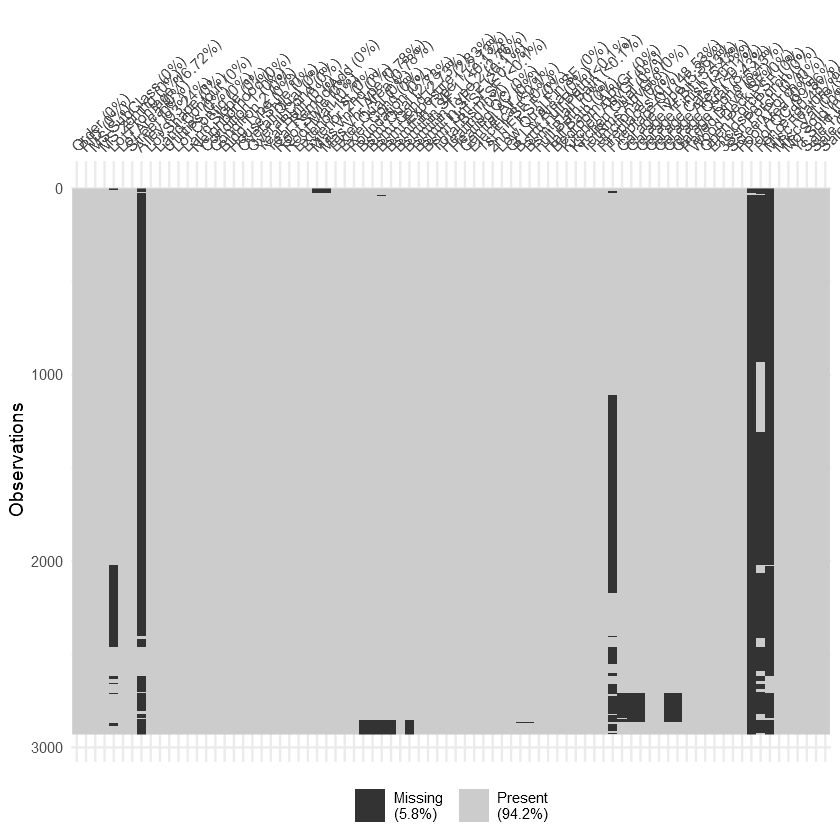

In [38]:
library(visdat)
vis_miss(AmesHousing::ames_raw, cluster = T)

#### 결측값 대체

- 중앙값 대체 : ```step_medianimpute()```
- 최빈값 대체 : ```step_modeimpute()```
- KNN 대체 : ```step_knnimpute()```
- 트리기반 대체 : ```step_bagimpute()```

In [49]:
# 결측값을 Gr_Liv_Area의 중앙값으로 대체
ames_recipe %>%
  step_medianimpute(Gr_Liv_Area)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Median imputation for Gr_Liv_Area

In [50]:
ames_recipe %>%
  step_knnimpute(all_predictors(), neighbors = 6)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
K-nearest neighbor imputation for all_predictors()

In [52]:
ames_recipe %>%
  step_bagimpute(all_predictors())

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Bagged tree imputation for all_predictors()

### 전처리
- 0 및 거의 0에 가까운 분산 변수는 제거해야 할 낮은 결과
- 특성이 단일 고유 값만 포함한다는 의미의 제로 분산 변수는 모델에 유용한 정보를 제공하지 않는다.

#### Normalization

- step_center(var) - 평균을 빼서 중심 이동
- step_normalize(var) - 평균 빼고, 분산으로 나눠서 표준화

##### Filters

- step_corr(threshold = 0.9) - 상관계수 절대값이 큰 변수 제거

- step_rm(var) - 변수 제거

- step_zv() - 분산이 0인 변수 제거

- step_nzv() - 분산이 거의 0인 변수 제거

#### Transformations

- step_log(var, base = exp(1) ) - 로그 변환

- step_logit(var) - 로짓 변환

- step_poly(var, degree = 2) - 변수에 polynomial term 추가(glm에서 poly() 와 동일, 즉 orthogonal polynomial 이용)

- step_BoxCox() - Boxcox 변환

- step_YeoJohnson - YeoJohnson 변환

#### Discretization

- step_discretize(var, num_breaks = 4) - 연속형 변수 이산형으로 변환

- step_cut() - 연속형 변수를 지정한 값을 기준으로 이산형으로 변환

     -include_outside_range - 지정한 범위를 넘어선 값을 양끝 break에 포함시킬지 여부. default = FALSE이며 결측치 처리됨

     - breaks - 절단 기준이 되는 값

#### Dummy variables and encodings

- step_string2factor - 문자를 요인형으로

- step_date() - date 변수에서 year, month, day of week 변수를 새롭게 생성

     - feature = c(‘dow’, ‘month’, ‘year’) - 요일, 달, 연도 변수 추가

     - abbr = T - Sunday or Sun

     - label = Sunday or number

- step_holiday() - date 변수에서 공휴일에 관한 이진변수 새롭게 생성

     - holidays = c(‘LaborDay’, ‘NewYearDay’, ‘ChristmasDay’)

     - holidays = timeDate::listHolidays(‘US’)

- step_dummy() - character or factor 변수를 더미변수로 변환

     - one_hot = TRUE - C +1개의 더미변수 생성(one_hot = F: C-1개 더미변수 생성

- step_other() - 범주형 변수의 level이 여러개일 때, 하위 범주를 기타로 묶음

    - threshold = 0.05 - 하위 5% 범주는 기타로 묶임

    - other : 기타로 지정할 level 이름 지정

- step_interact() - 상호작용 항 추가

* 거의 0에 가까운 분산 특성을 감지하기 위한 경험 법칙
1. 표본 크기에 대한 고유 값의 비율이 낮습니다(예: ≤10%).
2. 가장 널리 퍼진 값의 빈도 대 두 번째로 널리 퍼진 값의 빈도 비율이 큽니다(예: ≥20%).

- 두 기준이 모두 참이면 모델에서 변수를 제거하는 것이 종종 유리 
- Ames 데이터의 경우 분산 예측 변수가 0이 아니지만 거의 0에 가까운 임계값을 충족하는 기능이 20개

In [62]:
# nzv = near zero variance
caret::nearZeroVar(ames_train, saveMetrics = TRUE) %>% 
  tibble::rownames_to_column() %>% 
  filter(nzv) %>% head

,rowname,freqRatio,percentUnique,zeroVar,nzv
,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
1,Street,170.08333,0.09741841,FALSE,TRUE
2,Alley,23.03614,0.14612762,FALSE,TRUE
3,Land_Contour,20.69663,0.19483682,FALSE,TRUE
4,Utilities,1025.00000,0.14612762,FALSE,TRUE
5,Land_Slope,21.67778,0.14612762,FALSE,TRUE
6,Condition_2,254.37500,0.29225524,FALSE,TRUE


#### 0 또는 0에 가까운 분산 기능을 제거하기 위해 .ames_recipe에 ```step_zv()```및 ```step_nzv()```를 추가가능

### 수치형 변수 엔지니어링

### 왜도
- 비모수 모델은 편향된 기능의 영향을 거의 받지 않음. 
- 그러나 기능을 정규화하는 것은 이러한 모델의 성능에 부정적인 영향을 미치지 않는다. - 예를 들어, 기능을 정규화하면 트리 기반 알고리즘에서 최적의 분할점만 이동. 따라서 의심스러운 경우 정규화

### 정규화

In [63]:
recipe(Sale_Price ~ ., data = ames_train) %>%
  step_YeoJohnson(all_numeric()) 

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Yeo-Johnson transformation on all_numeric()

### 표준화

In [64]:
ames_recipe %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes())

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Log transformation on all_outcomes()
Centering for all_numeric(), -all_outcomes()
Scaling for all_numeric(), -all_outcomes()

### 범주형 변수 엔지니어링

### 덩어리 lumping

In [71]:
count(ames_train, Neighborhood) %>% arrange(n) %>% print

# A tibble: 28 x 2
   Neighborhood            n
   <fct>               <int>
 1 Green_Hills             1
 2 Landmark                1
 3 Greens                  4
 4 Blueste                 8
 5 Veenker                16
 6 Northpark_Villa        17
 7 Bloomington_Heights    18
 8 Meadow_Village         22
 9 Briardale              23
10 Clear_Creek            26
# ... with 18 more rows


- Neighborhood변수에는 28개의 범주가 있지만, 그중 몇개는 관찰 값 수가 적다

In [88]:
count(ames_train, Screen_Porch) %>% head

Screen_Porch,n
<int>,<int>
0,1873
40,1
60,1
80,1
84,1
88,1


- Screen_Porch변수는 수치형 변수이지만 대부분의 값이 0
#### 이러한 항목을 더 적은 수의 범주로 축소하거나, 집합

#### ```step_other()```

In [123]:
# Neighborhood의 하위 1%의 범주들을 other범주로
# Screen_Porch의 하위 10%의 범주들을 >0 범주로
lumping <- recipe(Sale_Price ~ ., data = ames_train) %>%
  step_other(Neighborhood, threshold = 0.01, 
             other = "other") %>% 
  step_other(Screen_Porch, threshold = 0.1, 
             other = ">0")

In [83]:
apply_2_training <- prep(lumping, training = ames_train) %>%
  bake(ames_train)

In [95]:
count(apply_2_training, Neighborhood) %>% arrange(n) %>% print

# A tibble: 22 x 2
   Neighborhood                                n
   <fct>                                   <int>
 1 Meadow_Village                             22
 2 Briardale                                  23
 3 Clear_Creek                                26
 4 South_and_West_of_Iowa_State_University    33
 5 Stone_Brook                                37
 6 Northridge                                 49
 7 Timberland                                 50
 8 other                                      65
 9 Iowa_DOT_and_Rail_Road                     73
10 Brookside                                  74
# ... with 12 more rows


In [86]:
count(apply_2_training, Screen_Porch) %>% arrange(n)

Screen_Porch,n
<fct>,<int>
>0,180
0,1873


### 원-핫 인코딩

<img src = "https://bradleyboehmke.github.io/HOML/images/ohe-vs-dummy.png">

#### ```step_dummy()```

In [98]:
recipe(Sale_Price ~ ., data = ames_train) %>%
  step_dummy(all_nominal(), one_hot = TRUE)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Dummy variables from all_nominal()

### 라벨 인코딩

In [102]:
count(ames_train, MS_SubClass) %>% head

MS_SubClass,n
<fct>,<int>
One_Story_1946_and_Newer_All_Styles,750
One_Story_1945_and_Older,95
One_Story_with_Finished_Attic_All_Ages,4
One_and_Half_Story_Unfinished_All_Ages,13
One_and_Half_Story_Finished_All_Ages,208
Two_Story_1946_and_Newer,403


#### MS_SubClass 변수에는 16개의 범주들이 존재

#### ```step_integer() ```

In [106]:
# MS_SubClass의 범주 라벨을 숫자로 변경
recipe(Sale_Price ~ ., data = ames_train) %>%
  step_integer(MS_SubClass) %>%
  prep(ames_train) %>%
  bake(ames_train) %>%
  count(MS_SubClass) %>% head

MS_SubClass,n
<dbl>,<int>
1,750
2,95
3,4
4,13
5,208
6,403


#### 순서형 변수들의 범주 라벨을 변경

In [110]:
count(ames_train, Overall_Qual) %>% head

Overall_Qual,n
<fct>,<int>
Very_Poor,3
Poor,9
Fair,33
Below_Average,147
Average,583
Above_Average,514


In [111]:
recipe(Sale_Price ~ ., data = ames_train) %>%
  step_integer(Overall_Qual) %>%
  prep(ames_train) %>%
  bake(ames_train) %>%
  count(Overall_Qual) %>% head

Overall_Qual,n
<dbl>,<int>
1,3
2,9
3,33
4,147
5,583
6,514


### 차원 축소

In [113]:
recipe(Sale_Price ~ ., data = ames_train) %>%
  step_center(all_numeric()) %>%
  step_scale(all_numeric()) %>%
  step_pca(all_numeric(), threshold = .95)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Centering for all_numeric()
Scaling for all_numeric()
PCA extraction with all_numeric()

### 순차적 단계
1. 0 또는 0에 가까운 분산 기능을 필터링합니다.
2. 필요한 경우 결측값 대체를 수행합니다.
3. 숫자 특징 왜곡을 해결하기 위해 정규화합니다.
4. 숫자 기능을 표준화합니다.
5. 숫자 기능에 대해 차원 축소(예: PCA)를 수행합니다.
6. 원-핫 또는 더미는 범주형 기능을 인코딩합니다.

### #
### recipe 
1. recipe : 전처리 단계 정의
2. prep : 훈련 데이터 기반으로 변수 매개변수 추정
3. bake : 새로운 데이터에 적용

In [117]:
blueprint <- recipe(Sale_Price ~ ., data = ames_train) %>%
    step_nzv(all_nominal())  %>% 
    # 분산이 0에 가까운 범주형 변수를 제거
    step_integer(matches("Qual|Cond|QC|Qu")) %>%
    # 순서형 변수들의 라벨을 숫자로 변경
    step_center(all_numeric(), -all_outcomes()) %>%
    step_scale(all_numeric(), -all_outcomes()) %>%
    # 모든 수치형 변수들을 표준화
    step_pca(all_numeric(), -all_outcomes())
    # 모든 수치형 변수들에 PCA를 적용하여 차원 축소를 수행
blueprint

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Operations:

Sparse, unbalanced variable filter on all_nominal()
Integer encoding for matches("Qual|Cond|QC|Qu")
Centering for all_numeric(), -all_outcomes()
Scaling for all_numeric(), -all_outcomes()
PCA extraction with all_numeric(), -all_outcomes()

In [118]:
prepare <- prep(blueprint, training = ames_train)
prepare

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         80

Training data contained 2053 data points and no missing data.

Operations:

Sparse, unbalanced variable filter removed Street, Alley, Land_Contour, Utilities,... [trained]
Integer encoding for Condition_1, Overall_Qual, Overall_Cond, Exter_Qual, Exte... [trained]
Centering for Lot_Frontage, Lot_Area, Condition_1, Overall_Qu... [trained]
Scaling for Lot_Frontage, Lot_Area, Condition_1, Overall_Qu... [trained]
PCA extraction with Lot_Frontage, Lot_Area, Condition_1, Overall_Qua... [trained]

In [124]:
baked_train <- bake(prepare, new_data = ames_train)
baked_test <- bake(prepare, new_data = ames_test)
baked_train %>% dim
ames_train %>% dim

[1] 2053   27

[1] 2053   81

In [125]:
blueprint <- recipe(Sale_Price ~ ., data = ames_train) %>%
  step_nzv(all_nominal()) %>%
  step_integer(matches("Qual|Cond|QC|Qu")) %>%
  step_center(all_numeric(), -all_outcomes()) %>%
  step_scale(all_numeric(), -all_outcomes()) %>%
  step_dummy(all_nominal(), -all_outcomes(), one_hot = TRUE)

In [141]:
library(caret)
cv <- trainControl(
    method = "repeatedcv",
    number = 10,
    repeats = 5
)

In [133]:
hyper_grid <- expand.grid(k = seq(2, 25, by = 1))

In [134]:
knn_fit2 <- train(
  blueprint, 
  data = ames_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE"
)

In [135]:
attributes(knn_fit2)

$names
 [1] "method"       "modelInfo"    "modelType"    "recipe"       "results"     
 [6] "pred"         "bestTune"     "call"         "dots"         "metric"      
[11] "control"      "finalModel"   "trainingData" "resample"     "resampledCM" 
[16] "perfNames"    "maximize"     "yLimits"      "times"        "levels"      
[21] "rs_seed"     

$class
[1] "train.recipe" "train"

In [140]:
knn_fit2$bestTune %>% print

  k
8 9


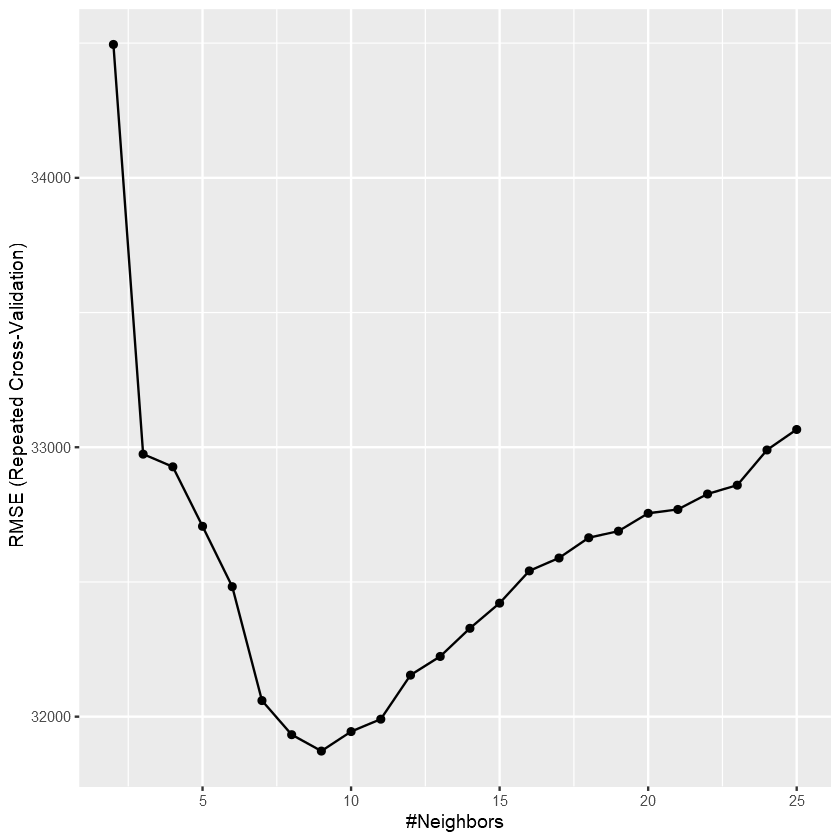

In [136]:
ggplot(knn_fit2)